Found 770 images belonging to 2 classes.
 Predicting with Custom CNN


/home/tiamat_hd/ThesisWork/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 Predicting with MobileNetV2
 Predicting with ResNet50
 Predicting with VGG16


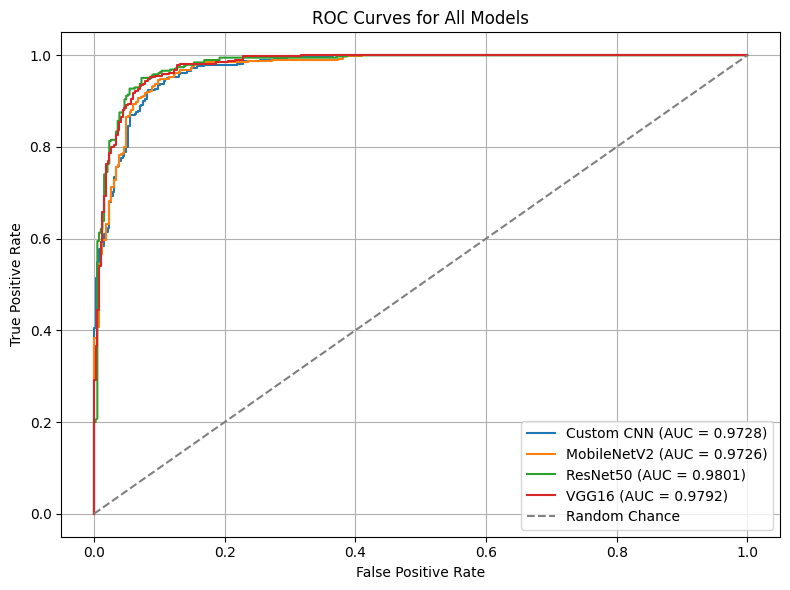

 ROC plot saved as 'roc_curves_all_models.png'
 Saved: all_model_predictions.csv

 Common False Positives across all models: 17
   NRG/EyePACS-TRAIN-NRG-2892.jpg
   NRG/EyePACS-TRAIN-NRG-2924.jpg
   NRG/EyePACS-TRAIN-NRG-2930.jpg
   NRG/EyePACS-TRAIN-NRG-2955.jpg
   NRG/EyePACS-TRAIN-NRG-2977.jpg
   NRG/EyePACS-TRAIN-NRG-3007.jpg
   NRG/EyePACS-TRAIN-NRG-3010.jpg
   NRG/EyePACS-TRAIN-NRG-3027.jpg
   NRG/EyePACS-TRAIN-NRG-3084.jpg
   NRG/EyePACS-TRAIN-NRG-3093.jpg
   NRG/EyePACS-TRAIN-NRG-3096.jpg
   NRG/EyePACS-TRAIN-NRG-3103.jpg
   NRG/EyePACS-TRAIN-NRG-3134.jpg
   NRG/EyePACS-TRAIN-NRG-3146.jpg
   NRG/EyePACS-TRAIN-NRG-3183.jpg
   NRG/EyePACS-TRAIN-NRG-3189.jpg
   NRG/EyePACS-TRAIN-NRG-3204.jpg

 Common False Negatives across all models: 4
   RG/EyePACS-TRAIN-RG-2946.jpg
   RG/EyePACS-TRAIN-RG-3005.jpg
   RG/EyePACS-TRAIN-RG-3163.jpg
   RG/EyePACS-TRAIN-RG-3262.jpg


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gc
import pandas as pd
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

# CONFIGURATION 
model_folder = './Best Models'
test_data_dir = './test'
pred_cache_dir = './predictions'
img_size = (224, 224)
batch_size = 1

os.makedirs(pred_cache_dir, exist_ok=True)

# Load test set once (no shuffle) 
datagen = ImageDataGenerator(rescale=1./255)
test_batches = datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

true_labels = test_batches.labels
filenames = test_batches.filenames

# Prediction cache function 
def get_cached_predictions(model_path, model_name):
    cache_file = os.path.join(pred_cache_dir, f"{model_name}_preds.npy")
    if os.path.exists(cache_file):
        print(f" Using cached predictions for {model_name}")
        return np.load(cache_file)
    print(f" Predicting with {model_name}")
    model = load_model(model_path)
    probs = model.predict(test_batches, verbose=0).flatten()
    np.save(cache_file, probs)
    del model
    K.clear_session()
    gc.collect()
    return probs

# Setup for ROC and analysis 
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors
model_files = sorted([f for f in os.listdir(model_folder) if f.endswith('.keras')])
prediction_df = pd.DataFrame({'filename': filenames, 'true_label': true_labels})

# Loop through models 
for i, model_file in enumerate(model_files):
    model_name = os.path.splitext(model_file)[0]
    model_path = os.path.join(model_folder, model_file)

    probs = get_cached_predictions(model_path, model_name)
    fpr, tpr, _ = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.4f})", color=colors[i % len(colors)])

    # Save probabilities
    prediction_df[f'prob_{model_name}'] = probs
    prediction_df[f'pred_{model_name}'] = (probs >= 0.5).astype(int)

# Plot formatting 
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curves_all_models.png", dpi=1200)
plt.show()
print(" ROC plot saved as 'roc_curves_all_models.png'")

# Save predictions to CSV 
prediction_df.to_csv("all_model_predictions.csv", index=False)
print(" Saved: all_model_predictions.csv")

# Analyze overlapping FP and FN 
fp_dict, fn_dict = {}, {}
for model_name in [os.path.splitext(f)[0] for f in model_files]:
    preds = prediction_df[f'pred_{model_name}'].values
    labels = prediction_df['true_label'].values
    fps = prediction_df[(preds == 1) & (labels == 0)]['filename'].tolist()
    fns = prediction_df[(preds == 0) & (labels == 1)]['filename'].tolist()
    fp_dict[model_name] = set(fps)
    fn_dict[model_name] = set(fns)

# Check overlaps 
common_fp = set.intersection(*fp_dict.values()) if len(fp_dict) > 1 else set()
common_fn = set.intersection(*fn_dict.values()) if len(fn_dict) > 1 else set()

print(f"\n Common False Positives across all models: {len(common_fp)}")
for fn in sorted(common_fp): print("  ", fn)

print(f"\n Common False Negatives across all models: {len(common_fn)}")
for fn in sorted(common_fn): print("  ", fn)


In [12]:
from scipy.stats import shapiro, ttest_rel, wilcoxon
from itertools import combinations
import os

print("\n=== Statistical Comparison of Model Predictions ===")

# Extract model names from file names (e.g., "vgg16_model_final.keras" → "vgg16_model_final")
model_names = [os.path.splitext(f)[0] for f in model_files]

# Iterate through all unique pairs of models
for model_a, model_b in combinations(model_names, 2):
    probs_a = prediction_df[f'prob_{model_a}'].values
    probs_b = prediction_df[f'prob_{model_b}'].values
    diff = probs_a - probs_b

    # Normality test (Shapiro-Wilk)
    shapiro_p = shapiro(diff).pvalue

    # Choose statistical test based on normality
    if shapiro_p > 0.05:
        stat, pval = ttest_rel(probs_a, probs_b)
        test_used = "Paired t-test"
    else:
        stat, pval = wilcoxon(probs_a, probs_b)
        test_used = "Wilcoxon signed-rank"

    significance = "Significant" if pval < 0.05 else "Not significant"

    # Report result
    print(f"\n{model_a} vs {model_b}")
    print(f"  Shapiro-Wilk p-value     = {shapiro_p:.2f}")
    print(f"  Test used                = {test_used}")
    print(f"  Test statistic           = {stat:.0f}")
    print(f"  p-value                  = {pval:.2f} → {significance}")



=== Statistical Comparison of Model Predictions ===

Custom_CNN_Final vs Resnet50_Model_Final
  Shapiro-Wilk p-value     = 0.00
  Test used                = Wilcoxon signed-rank
  Test statistic           = 146456
  p-value                  = 0.75 → Not significant

Custom_CNN_Final vs mobilenetv2_model_final
  Shapiro-Wilk p-value     = 0.00
  Test used                = Wilcoxon signed-rank
  Test statistic           = 134508
  p-value                  = 0.02 → Significant

Custom_CNN_Final vs vgg16_model_final
  Shapiro-Wilk p-value     = 0.00
  Test used                = Wilcoxon signed-rank
  Test statistic           = 143117
  p-value                  = 0.43 → Not significant

Resnet50_Model_Final vs mobilenetv2_model_final
  Shapiro-Wilk p-value     = 0.00
  Test used                = Wilcoxon signed-rank
  Test statistic           = 126929
  p-value                  = 0.00 → Significant

Resnet50_Model_Final vs vgg16_model_final
  Shapiro-Wilk p-value     = 0.00
  Test used    